In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import glob
import pandas as pd

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Extending Fe Calibration to Additional Elements

We've calibrated our TAME measurements by using a sample of by-hand equivalent widths for comparison. As we expand our linelist, we'll want to apply similar calibration to those lines as well. This notebook explores general trends in the Fe calibration to use as a 0th order calibration for lines where we have no by-hand measurements.

### Distribution of Fe Lowercut Values

What is the most common lowercut value preferred by the Fe lines?

In [37]:
df = pd.read_csv("tame_linecorr.csv", delim_whitespace = True)

feII = [5018.44, 5234.63,5284.1,5325.56,5414.05,5425.25,5991.37,
        6084.1,6149.25,6247.58,6416.92,6432.68,6456.38]



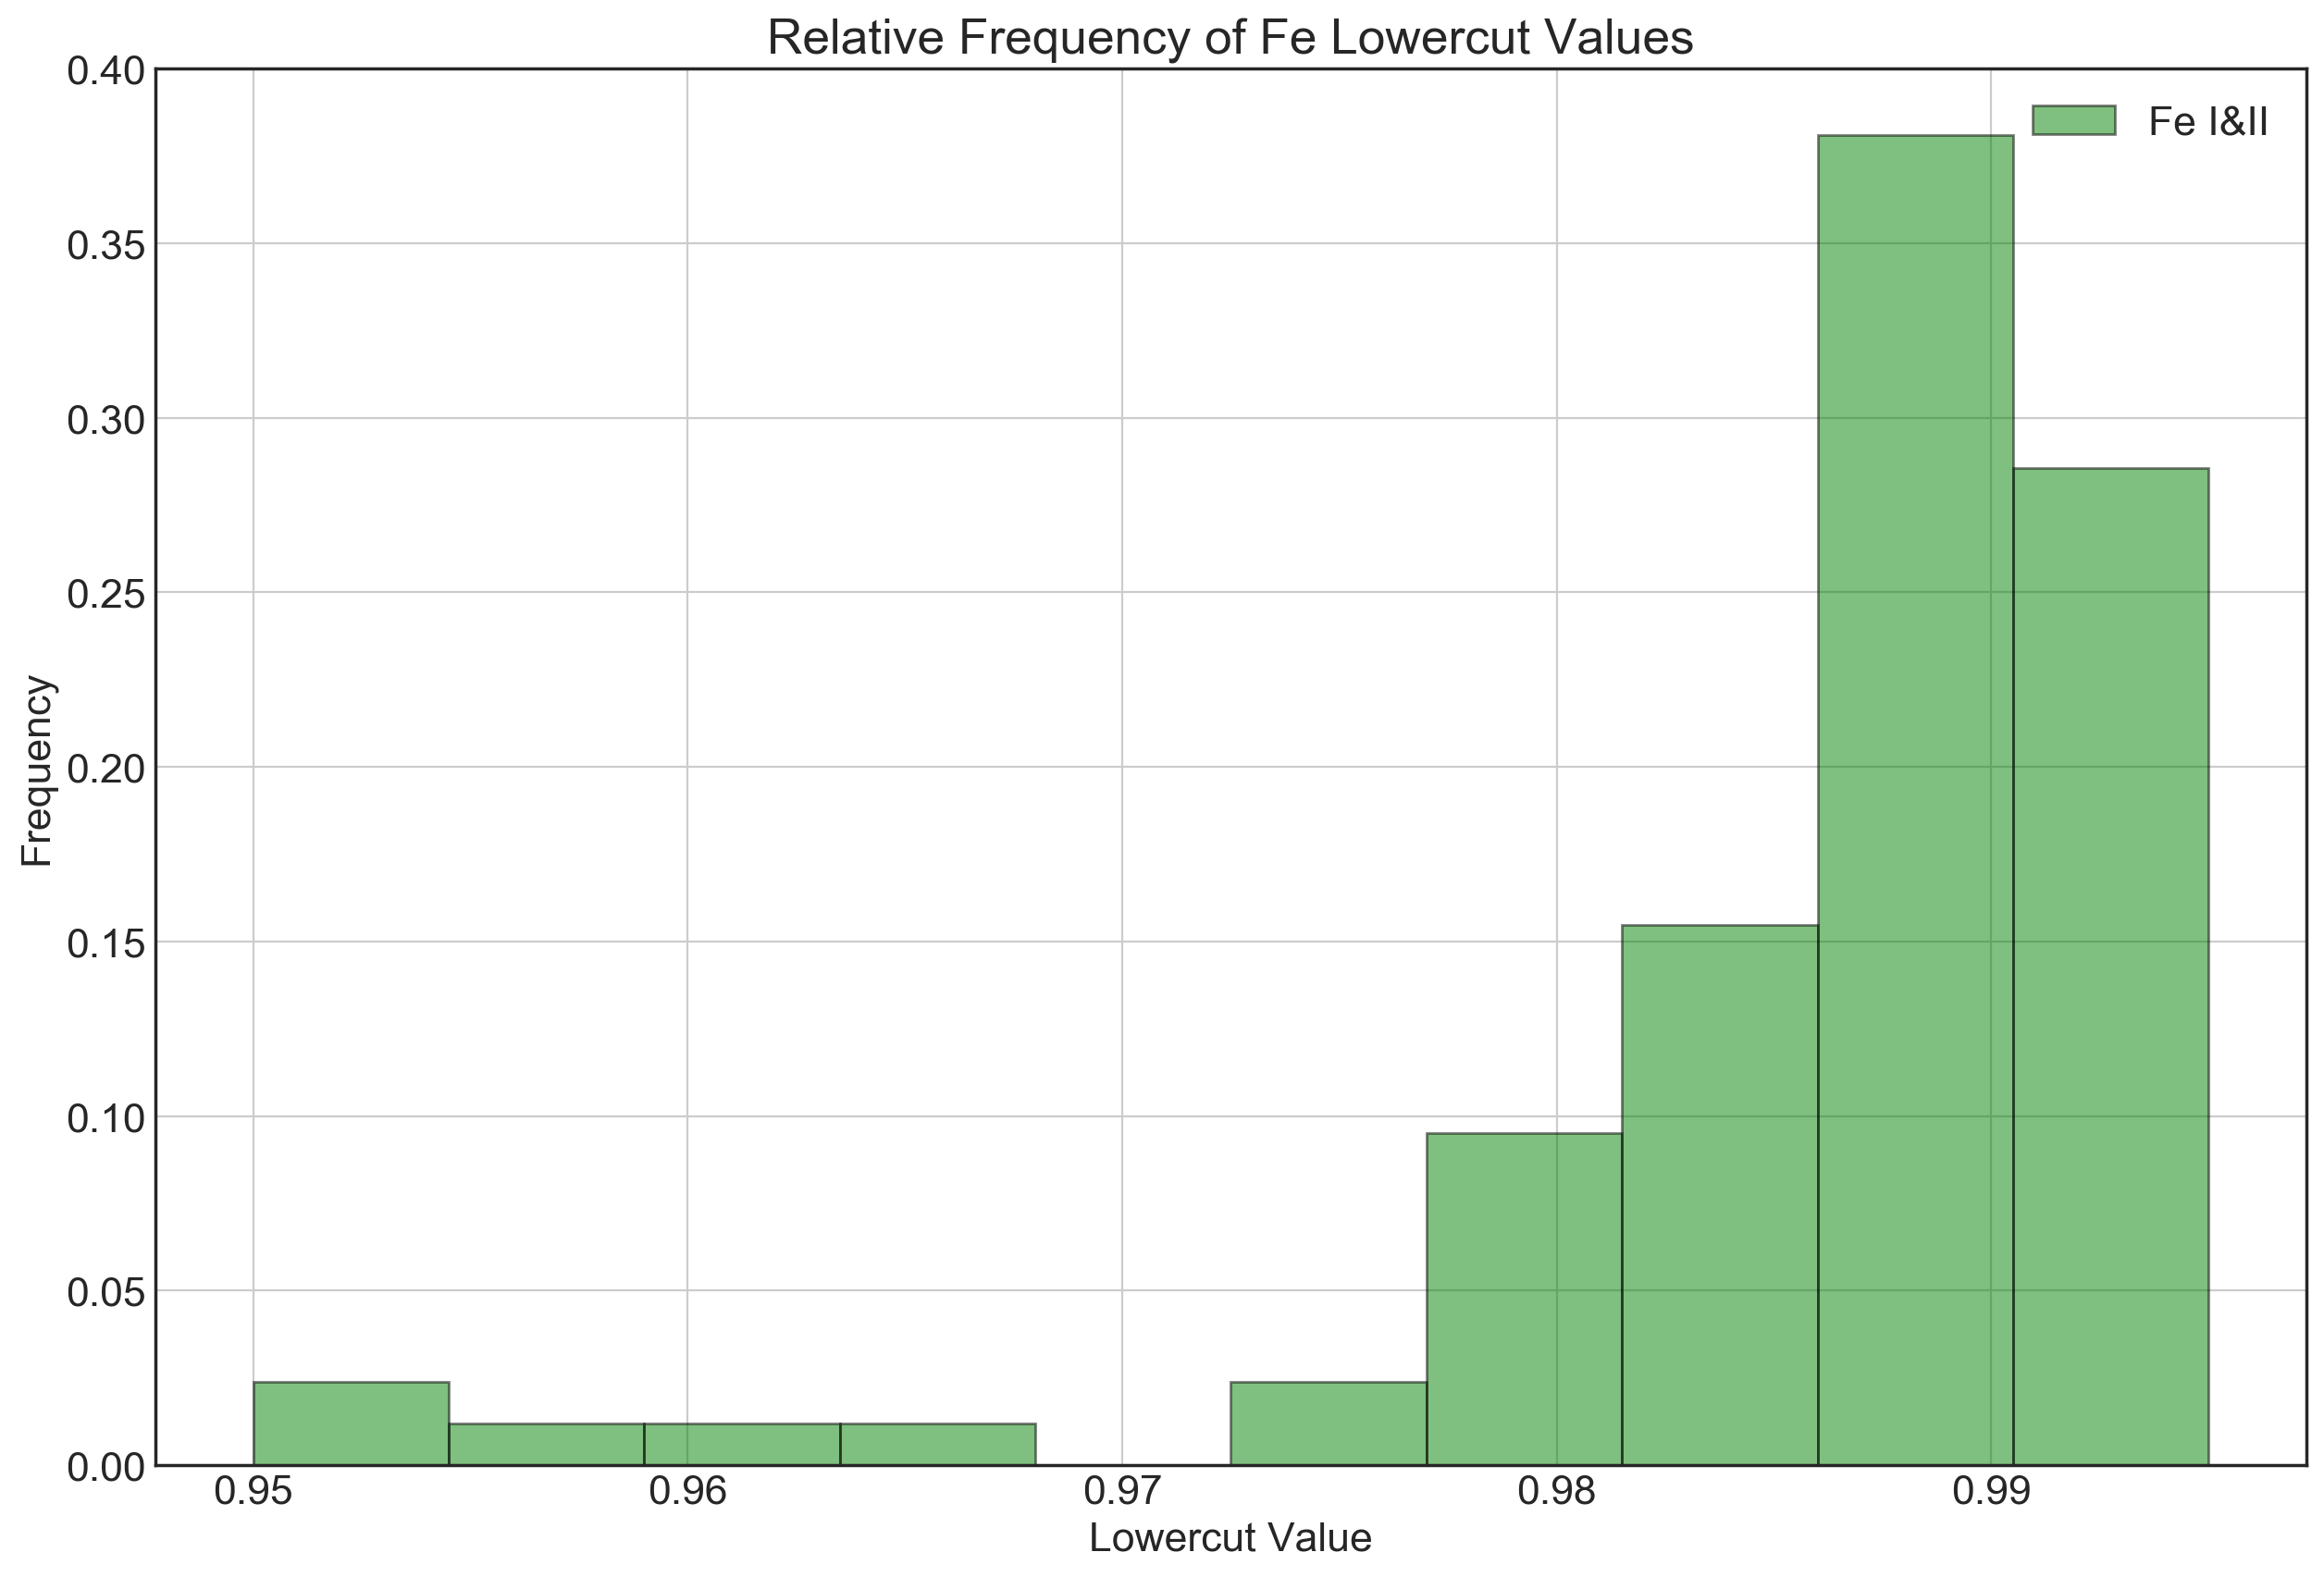

In [67]:
fig = plt.figure(figsize=(15,10), dpi = 200)
plt.grid()
plt.title("Relative Frequency of Fe Lowercut Values")
plt.xlabel("Lowercut Value")
plt.ylabel("Frequency")

bins=np.histogram(np.hstack(df['Lowercut']), bins=10)[1] #designate a consistent binsize across 
plt.hist(df['Lowercut'], histtype='bar', ec='black', bins=bins, color='g', alpha=0.5, 
         weights=np.zeros_like(df['Lowercut']) + 1. / len(df['Lowercut']), label = "Fe I&II")
plt.legend()

Is there a distribution difference between the Fe ionization states?

From this sample size, no. Both states have similar relative frequency for the common lowercut values and differ for the less common ones (which is likely just outlier noise). Since these are similar, this strengthens the case for assuming a similar distribution of lowercut values for any given element. Essentially, this distribution likely represents systematic TAME selection rather than element specific selection.

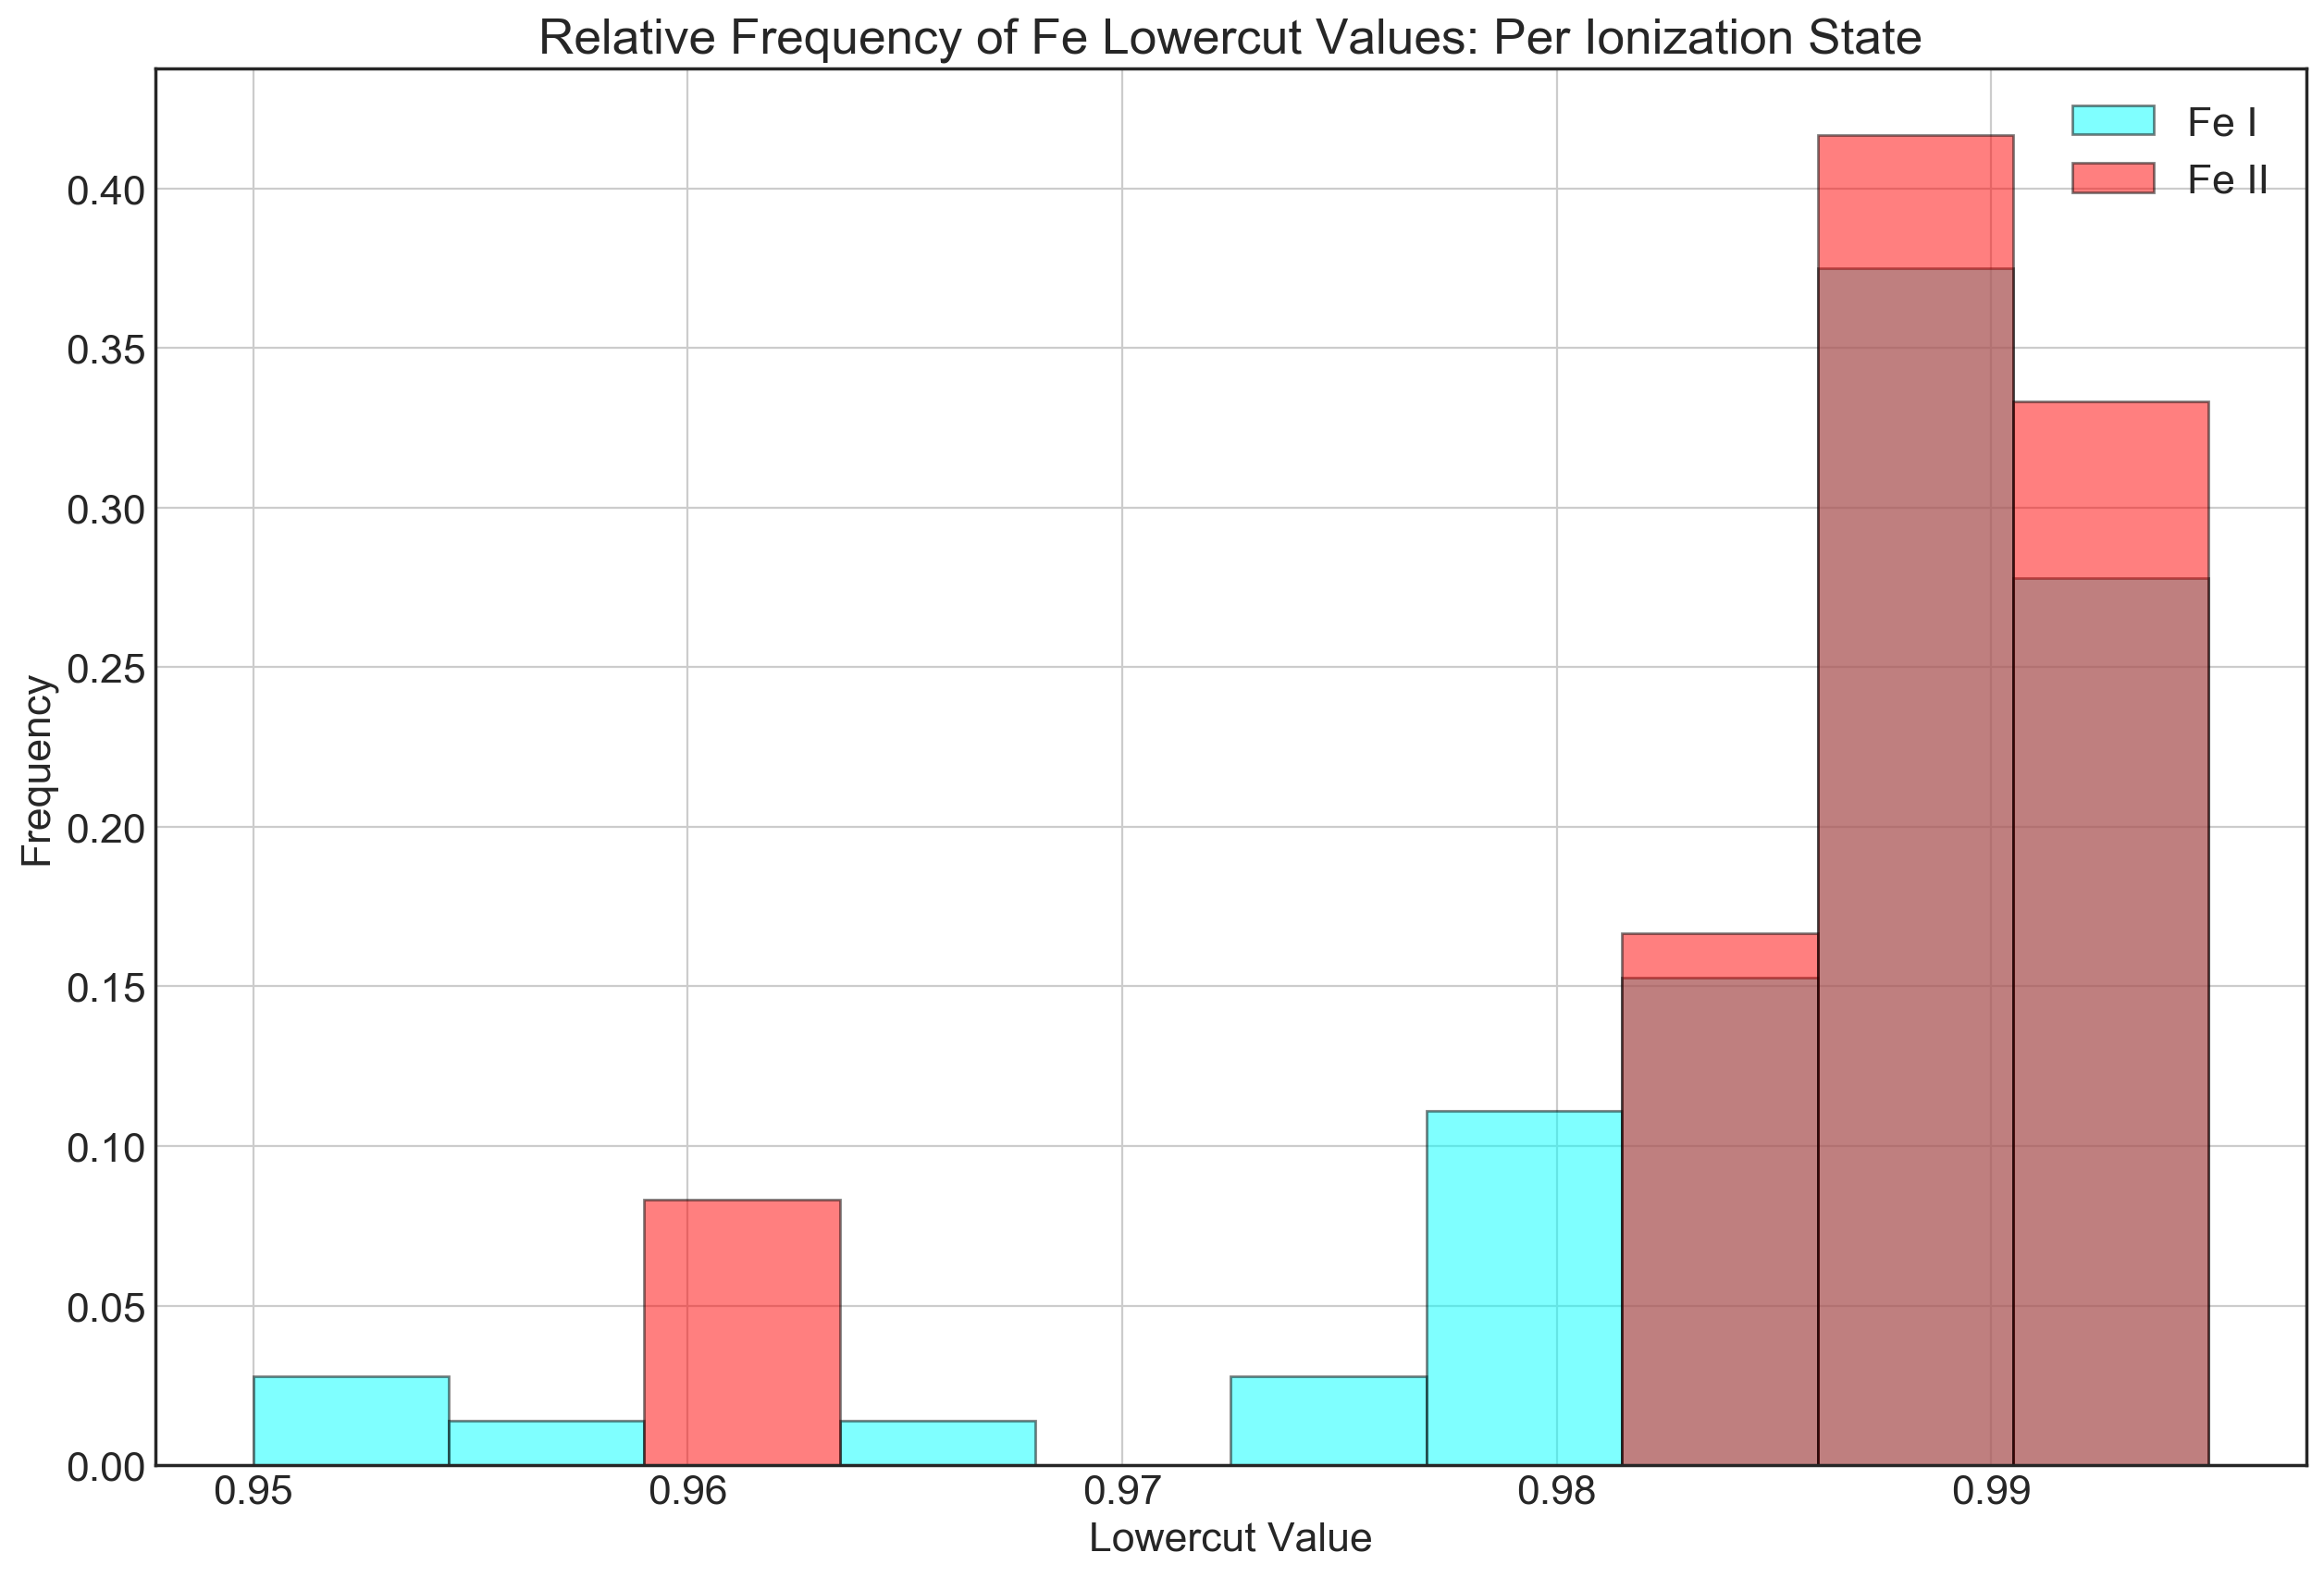

In [68]:
feI_lc = []
feII_lc = []
for line in np.array(df['Line']):
    idx = df[df['Line']==line].index.values.astype(int)[0]
    if line in feII:
        feII_lc.append(df['Lowercut'][idx])
    else:
        feI_lc.append(df['Lowercut'][idx])

fig = plt.figure(figsize=(15,10), dpi = 200)
plt.grid()
plt.title("Relative Frequency of Fe Lowercut Values: Per Ionization State")
plt.xlabel("Lowercut Value")
plt.ylabel("Frequency")

bins=np.histogram(np.hstack(df['Lowercut']), bins=10)[1] #designate a consistent binsize across 


plt.hist(feI_lc, histtype='bar', ec='black', bins=bins, color='cyan', alpha=0.5, 
         weights=np.zeros_like(feI_lc) + 1. / len(feI_lc), label = "Fe I")
plt.hist(feII_lc, histtype='bar', ec='black', bins=bins, color='r', alpha=0.5, 
         weights=np.zeros_like(feII_lc) + 1. / len(feII_lc), label="Fe II")

plt.legend()